In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
datapath = "../../r01_abcd_dti/" 

In [3]:
abcd = pd.read_parquet(datapath + "abcd_twin_bundles.parquet")

In [4]:
chen = pd.read_parquet(datapath + "abcc_twin_bundle_stats_chen.parquet")
hao = pd.read_parquet(datapath + "abcc_twin_bundle_stats_hao.parquet")

In [5]:
print(len(chen))
print(len(hao))

101336
101548


In [6]:
chen = chen[chen["number_of_tracts"].notna()]
hao = hao[hao["number_of_tracts"].notna()]
print(len(chen))
print(len(hao))

61778
61803


In [7]:
metrics = ['bundle_name',
                 'number_of_tracts',
                 'mean_length_mm',
                 'span_mm',
                 'curl',
                 'elongation',
                 'total_volume_mm3',
                 'first_quarter_volume_mm3',
                 'second_and_third_quarter_volume_mm3',
                 'fourth_quarter_volume_mm3',
                 'total_surface_area_mm2',
                 'total_radius_of_end_regions_mm',
                 'total_area_of_end_regions_mm2',
                 'irregularity',
                 'area_of_end_region_1_mm2',
                 'radius_of_end_region_1_mm',
                 'volume_of_end_branches_1',
                 'area_of_end_region_2_mm2',
                 'radius_of_end_region_2_mm',
                 'volume_of_end_branches_2',
                 'qa','dti_fa',
                 'txx','txy','txz','tyy','tyz','tzz',
                 'rd1','rd2','ha','md','ad','rd',
                 'gfa','iso','rdi',
                 'nrdi02L','nrdi04L','nrdi06L',
                 'subject_id', 'Manufacturer']

In [8]:
chen.rename(columns = {'1st_quarter_volume_mm3' : "first_quarter_volume_mm3",
                      '2nd_and_3rd_quarter_volume_mm3' : "second_and_third_quarter_volume_mm3",
                      '4th_quarter_volume_mm3' : "fourth_quarter_volume_mm3"}, inplace = True)
hao.rename(columns = {'1st_quarter_volume_mm3' : "first_quarter_volume_mm3",
                      '2nd_and_3rd_quarter_volume_mm3' : "second_and_third_quarter_volume_mm3",
                      '4th_quarter_volume_mm3' : "fourth_quarter_volume_mm3"}, inplace = True)

In [9]:
def corr_clustermap(df, dendro=False):
    corr = df.corr(numeric_only=True)
    cm = sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-1, vmax=1,
            cmap = "vlag", figsize=(12, 12))
    cm.ax_row_dendrogram.set_visible(dendro) # dendro: boolean, whether or not to plot dendrogram
    cm.ax_col_dendrogram.set_visible(dendro)
    plt.show()
    return corr

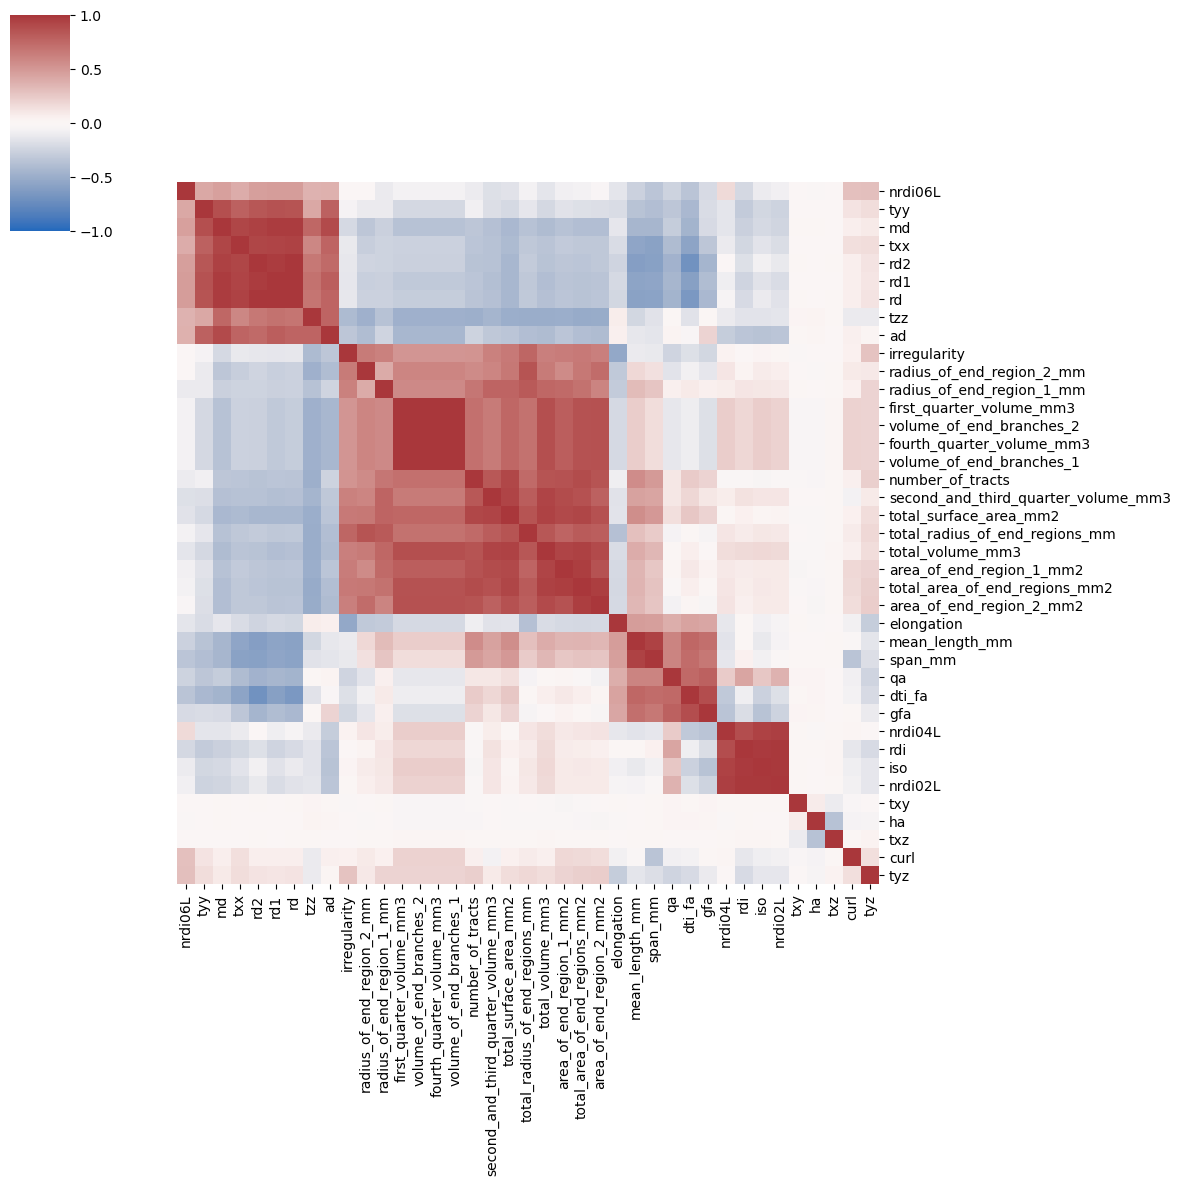

In [10]:
chen_corr = corr_clustermap(chen[metrics])

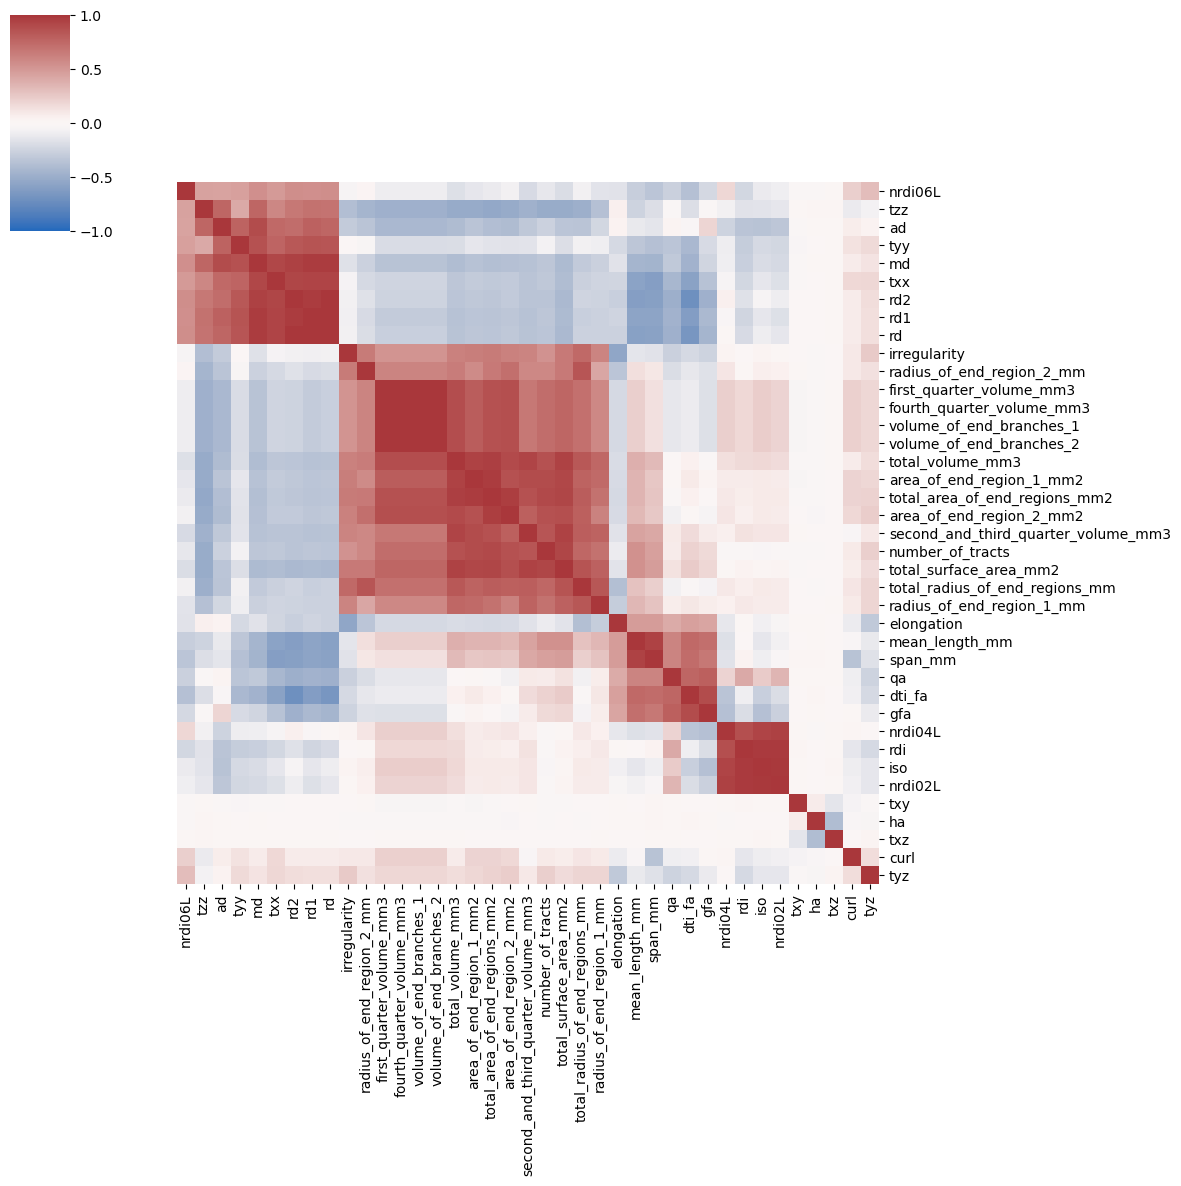

In [11]:
hao_corr = corr_clustermap(hao[metrics])

In [12]:
def bundle_category(bundle):
    if "Association" in bundle:
        return "Association"
    elif "ProjectionBasalGanglia" in bundle:
        return "ProjectionBasalGanglia"
    elif "ProjectionBrainstem" in bundle:
        return "Projection Brainstem"
    elif "Cerebellum" in bundle:
        return "Cerebellum"
    elif "CranialNerve" in bundle:
        return "Cranial Nerve"

In [13]:
hao["bundle_group"] = hao["bundle_name"].apply(lambda x: bundle_category(x))

In [14]:
hao["bundle_group"].unique()

array(['Association', 'ProjectionBasalGanglia', 'Projection Brainstem',
       'Cerebellum', 'Cranial Nerve'], dtype=object)

In [15]:
# for bundle_group in hao["bundle_group"].unique():
#     print(bundle_group)
#     corr_clustermap(hao[hao["bundle_group"] == bundle_group][metrics])

In [16]:
## Correlation maps look different across bundles
# for bundle in hao["bundle_name"].unique():
#     print(bundle)
#     corr_clustermap(hao[hao["bundle_name"] == bundle][metrics])

Correlation between metrics before and after update is mostly consistent

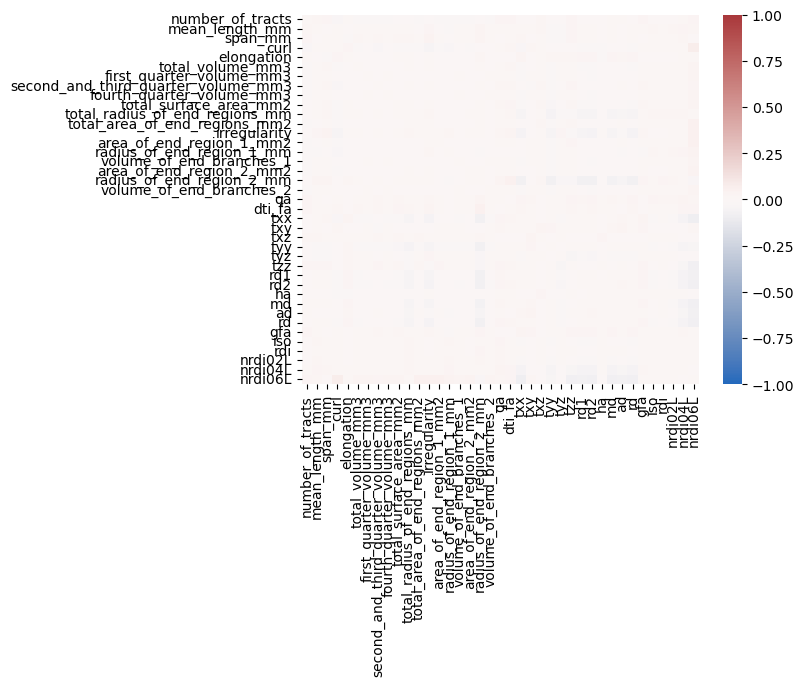

In [93]:
diff = chen_corr - hao_corr
sns.heatmap(diff, 
            xticklabels=chen_corr.columns.values,
            yticklabels=chen_corr.columns.values,
           vmin=-1, vmax=1, cmap="vlag")
plt.show()

In [ ]:
# for col in chen[metrics[1:-2]]:
# #     stat, p_value =  stats.ks_2samp(list(chen[col]), list(hao[col]))
#     stat, p_value =  stats.mannwhitneyu(list(chen[col]), list(hao[col]))
#     print(col + ": \n")
#     print(f"statistic: {stat}")
#     print(f"P-value: {p_value}" + "\n")
    
#     fig, ax = plt.subplots()
#     sns.histplot(data=chen, x=col, ax=ax, label="chen", stat="density")
#     sns.histplot(data=hao, x=col, ax=ax, label="hao", stat="density")
#     plt.legend()
#     plt.show()

In [ ]:
def anova(df):
    for col in df.columns[2:-2]:
        model = ols(col + ' ~ C(Manufacturer)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        if anova_table["PR(>F)"][0] < 0.05:     
            print("\n" + col)
            print(anova_table)

In [ ]:
# anova(chen[metrics])

In [ ]:
# anova(hao[metrics])

In [69]:
merged = pd.merge(hao, chen, on=["subject_id", "bundle_name"])

In [71]:
metrics = ['mean_length_mm',
                 'span_mm',
                 'curl',
                 'elongation',
                 'total_volume_mm3',
                 'first_quarter_volume_mm3',
                 'second_and_third_quarter_volume_mm3',
                 'fourth_quarter_volume_mm3',
                 'total_surface_area_mm2',
                 'total_radius_of_end_regions_mm',
                 'total_area_of_end_regions_mm2',
                 'irregularity',
                 'area_of_end_region_1_mm2',
                 'radius_of_end_region_1_mm',
                 'volume_of_end_branches_1',
                 'area_of_end_region_2_mm2',
                 'radius_of_end_region_2_mm',
                 'volume_of_end_branches_2',
                 'qa','dti_fa',
                 'txx','txy','txz','tyy','tyz','tzz',
                 'rd1','rd2','ha','md','ad','rd',
                 'gfa','iso','rdi',
                 'nrdi02L','nrdi04L','nrdi06L']

### Comparison of Hao and Chen datasets: subject-paired differences and correlations of metrics

In [85]:
for metric in metrics:
    diff = (merged[metric + "_x"] - merged[metric + "_y"])/merged[metric + "_x"]
    merged[metric + "Diff"] = diff

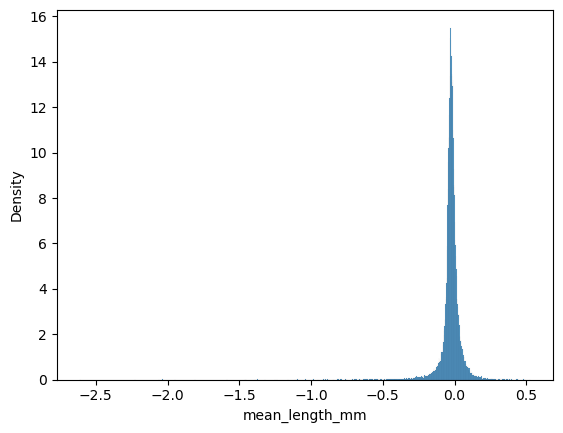

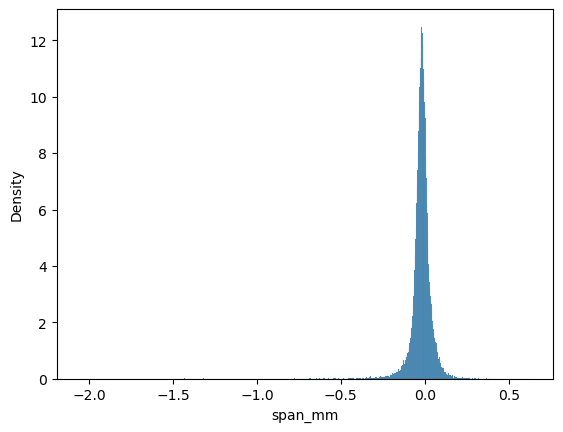

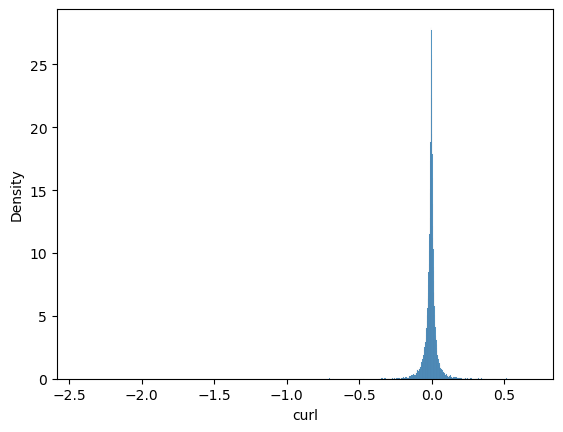

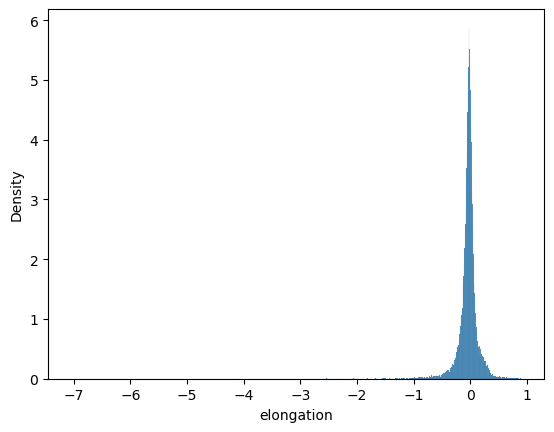

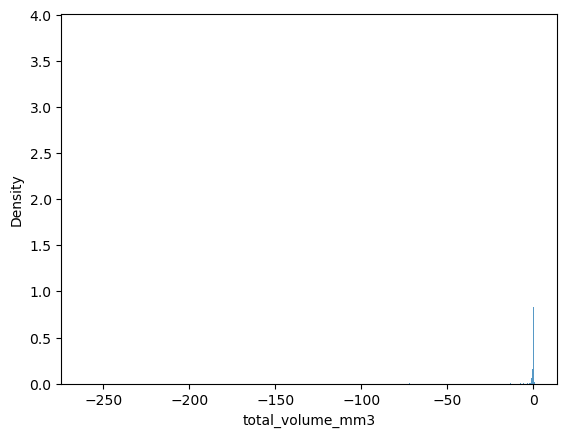

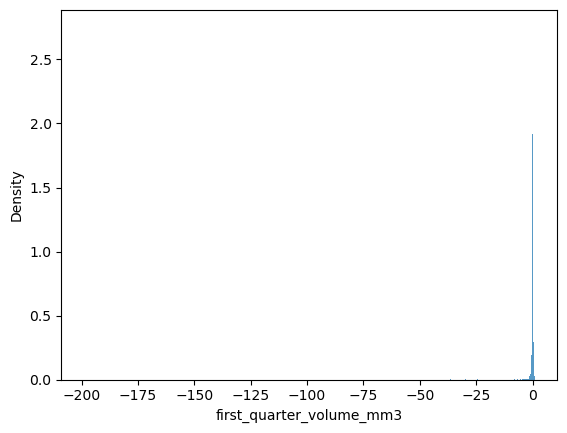

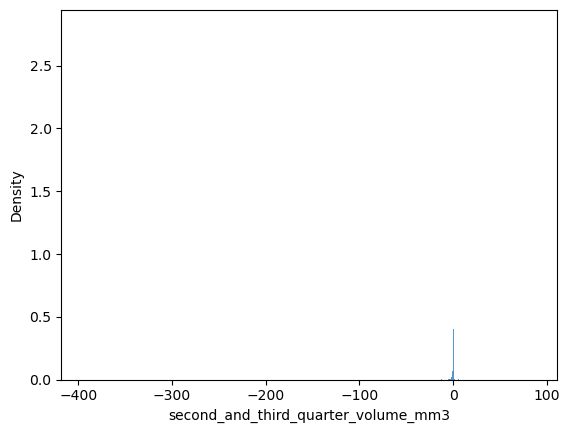

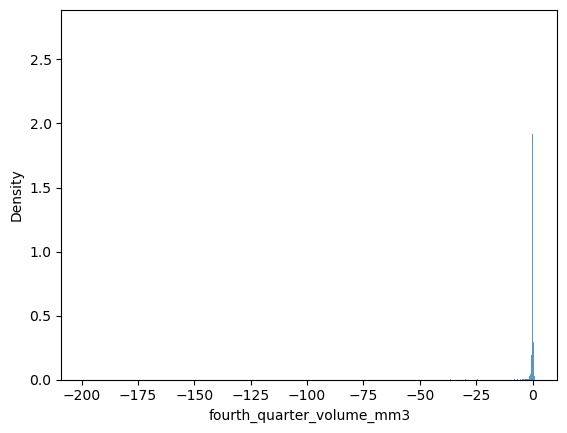

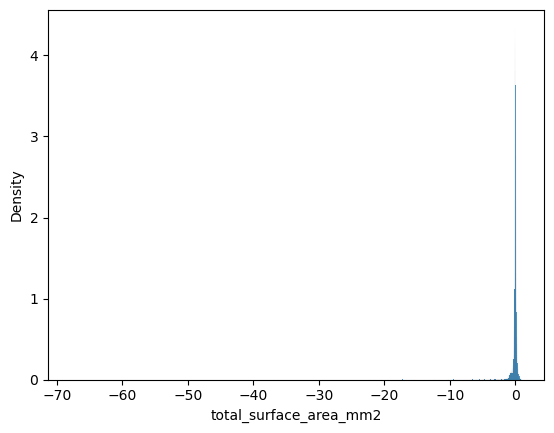

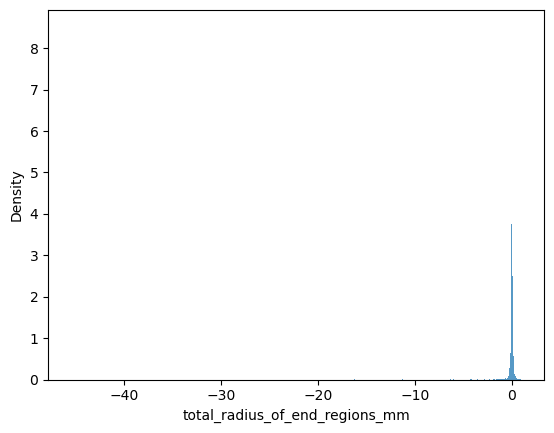

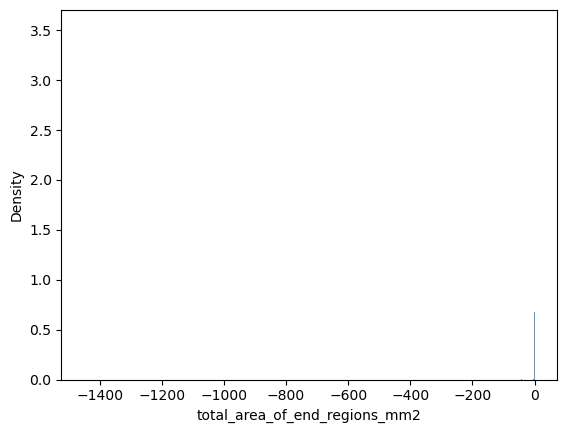

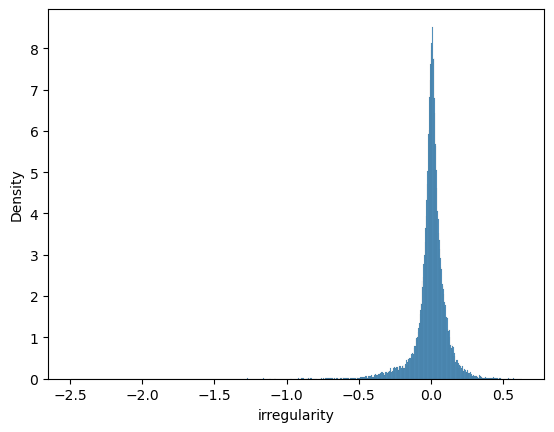

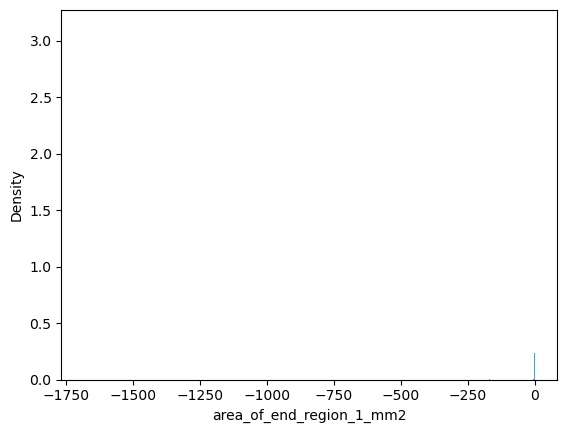

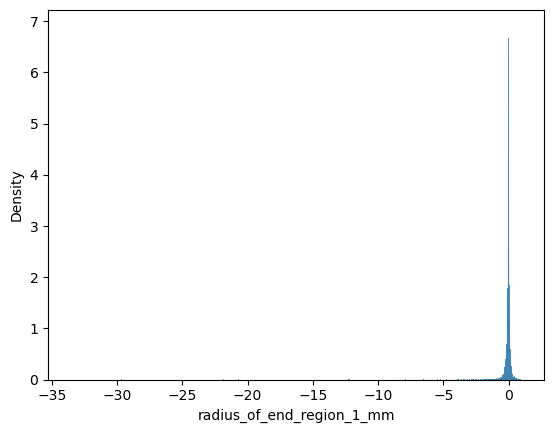

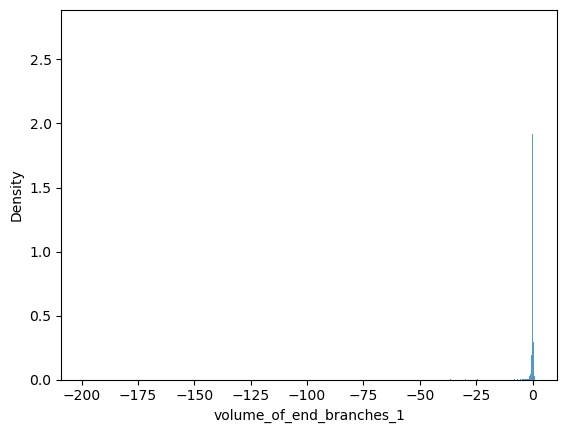

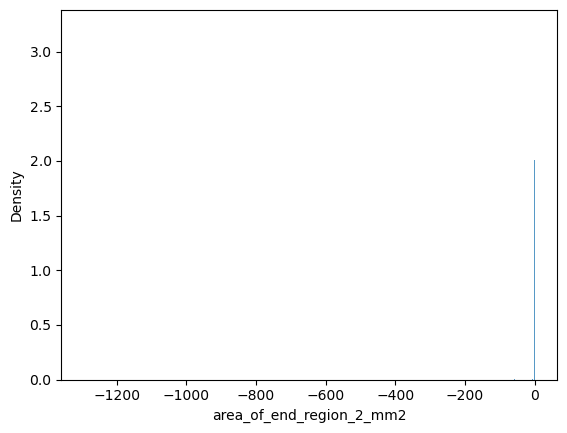

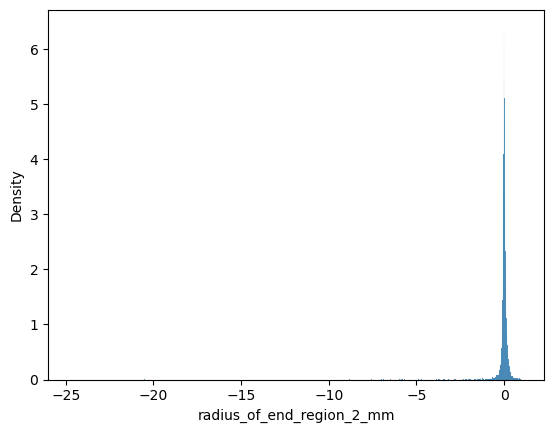

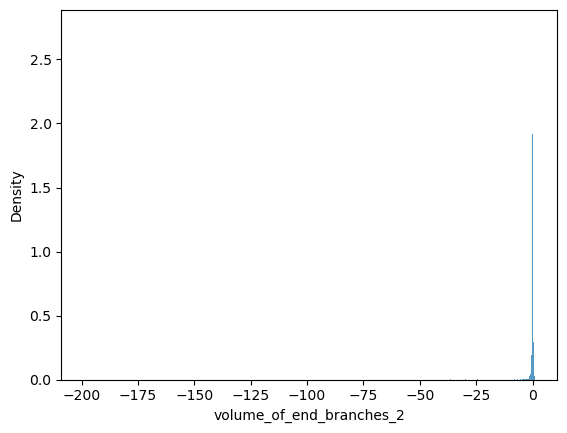

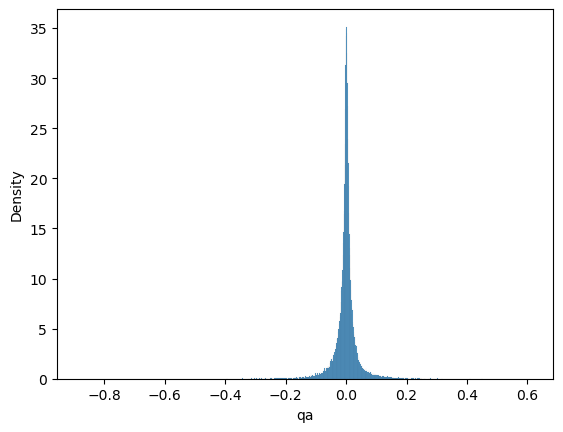

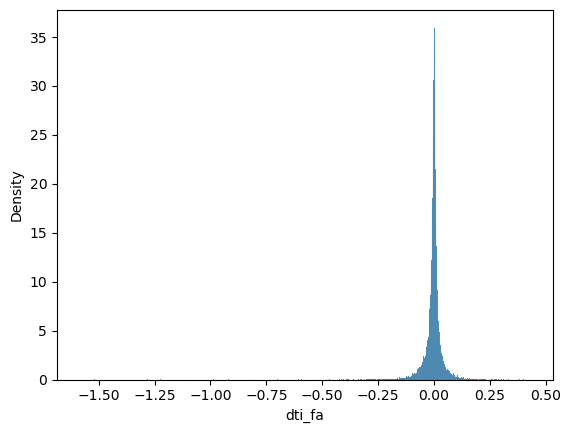

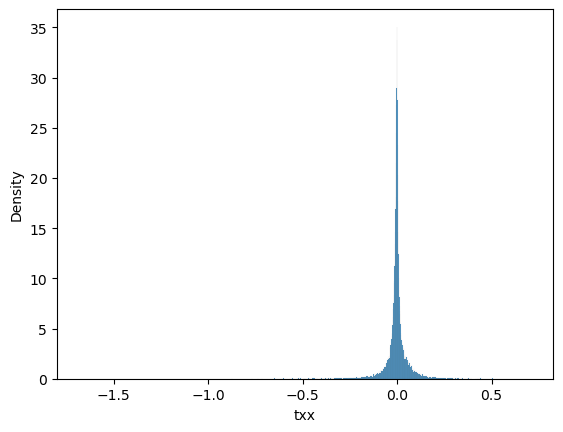


KeyboardInterrupt



In [81]:
for col in metrics:
    sns.histplot(data=merged, x=col+"Diff", stat="density")
    plt.show()

In [92]:
# Pearson correlation
# Curl shows the the lowest correlation valye at 0.779
for metric in metrics:
    correlation = merged[metric + "_x"].corr(merged[metric + "_y"])
    print(metric + " correlation: " + str(correlation))

mean_length_mm correlation: 0.9958857435251802
span_mm correlation: 0.9968013248507006
curl correlation: 0.9666121249521475
elongation correlation: 0.7791844564629591
total_volume_mm3 correlation: 0.9850523339422463
first_quarter_volume_mm3 correlation: 0.9871040142914165
second_and_third_quarter_volume_mm3 correlation: 0.9752934563146441
fourth_quarter_volume_mm3 correlation: 0.9871040142914165
total_surface_area_mm2 correlation: 0.9807881784538266
total_radius_of_end_regions_mm correlation: 0.9442937055908927
total_area_of_end_regions_mm2 correlation: 0.9854588246773212
irregularity correlation: 0.9169781882673275
area_of_end_region_1_mm2 correlation: 0.9824199573070056
radius_of_end_region_1_mm correlation: 0.9081858140032845
volume_of_end_branches_1 correlation: 0.9871040142914165
area_of_end_region_2_mm2 correlation: 0.9836195617881334
radius_of_end_region_2_mm correlation: 0.930403574878828
volume_of_end_branches_2 correlation: 0.9871040142914165
qa correlation: 0.987110174271769